In [ ]:
import pandas as pd
import numpy as np
import tweepy
import nltk
import re
import math
import matplotlib as mlt
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')  
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# install snscrape (https://github.com/JustAnotherArchivist/snscrape)

In [ ]:
# run this in the terminal window (change the dates and cashtags accordingly)
# snscrape twitter-search '$AAPL since:2020-11-01 until:2020-11-19' > AAPL_tweets_01_19_November.txt

In [106]:
# authentication keys for twitter API

consumer_key = "" 
consumer_secret = "" 
access_token= "" 
access_token_secret = ""
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [125]:
# reading the URLS into a pandas dataframe

tweet_url = pd.read_csv("AAPL_tweets_01_19_November.txt", index_col= None, header = None, names = ["links"])
tweet_url.head()

,links
0,https://twitter.com/PicassoCharts/status/13292...
1,https://twitter.com/LenovoLegion/status/130158...
2,https://twitter.com/jm_option/status/132921258...
3,https://twitter.com/frankblaze/status/13292123...
4,https://twitter.com/Brianfires/status/13292122...


In [126]:
# Stripping the tweet_ids

af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)

In [127]:
# converting the ids into a list for using in Tweepy
ids = tweet_url['id'].tolist()

In [128]:
# encountered errors when pulling all tweets at once, hence dividing into chunks

total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

In [129]:
# function to pull the tweets using tweepy

def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    
    # appending data into a csv file (each cashtag should have one file)
    empty_data.to_csv("apple_tweets.csv", mode="a")

In [130]:
# looping through the above loop again to pull tweets in chunks

for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

### Pre-processing of tweets

In [2]:
# reading in the tweets
apple_tweets = pd.read_csv("/Tweets/apple.csv") # the master data should go in here with the Tickr symbol as a column
apple_tweets.shape

/Users/sumo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(284837, 5)

In [3]:
# checking for the number of headers
apple_tweets['date'].value_counts()

date                   6031
2020-09-03 18:26:48    2373
2020-11-30 17:00:24     210
2020-11-23 15:14:07     148
2020-11-13 15:23:00      77
                       ... 
2020-11-04 05:46:16       1
2020-06-10 19:58:05       1
2020-05-01 14:12:38       1
2020-03-30 12:35:24       1
2020-10-20 18:49:06       1
Name: date, Length: 268734, dtype: int64

In [4]:
# finding out the index of the record with 'date' as value in date column and drop it
indexNames = apple_tweets[ apple_tweets['date'] == 'date' ].index
apple_tweets.drop(indexNames , inplace=True)

In [5]:
apple_tweets.shape

(278806, 5)

In [6]:
# functions to pre-process the tweets and calculate sentiment score

# this removes stopwords, lemmatizes, converts into lower case
def fix_text(text): 
    lemmatizer = WordNetLemmatizer() 
    stop_words = set(stopwords.words("english"))
    snow = nltk.stem.SnowballStemmer('english')
    letters_only = re.sub("[^a-zA-Z]"," ", str(text))
    words = letters_only.lower().split()
    meaningful = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return(" ".join(meaningful))

# this calculates the vader sentiment score
def sentimentScore(text):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in text:
        vs = analyzer.polarity_scores(sentence)
        results.append(vs)
    return results

In [7]:
# calling the function "fix_text" by applying it as a lambda function
apple_tweets['tweet'] = apple_tweets['tweet'].apply(fix_text)

# re-indexing the dataframe
apple_tweets = apple_tweets.reset_index().loc[:,apple_tweets.columns[0:]]

In [8]:
apple_tweets.head()

,Unnamed: 0,date,screen_name,tweet,tweet_id
0,0,2020-03-14 22:15:00,Benzinga,barron pick pan roundtable pick airline oil st...,1.2389517908647813e+18
1,1,2020-03-14 22:03:33,MacHashNews,apple employee say company culture secrecy mak...,1.2389489114876723e+18
2,2,2020-03-14 21:52:44,truthntrading,markrmorley thehurdygurdy cs astrojoe lt potte...,1.23894618826888e+18
3,3,2020-03-14 23:14:29,ChoZynTradeZ,e e f going test week close market jesus spy s...,1.23896676044501e+18
4,4,2020-03-14 23:03:26,BeltwayGreg,dafrankel carlquintanilla say one thing corona...,1.238963981001392e+18


In [9]:
# drop the unwanted columns
apple_tweets.drop(['tweet_id','Unnamed: 0'], axis = 1, inplace = True)

In [10]:
# finding out the index of records where the date value is not in the right format and drop them
indexNames = apple_tweets[ apple_tweets['date'].str.len() > 19 ].index
apple_tweets.drop(indexNames , inplace=True)

In [11]:
# convert the date column to datetime format, but strip the time
apple_tweets['date'] = pd.to_datetime(apple_tweets['date']).dt.date


# this step is because I am stupid, or maybe python is
apple_tweets['date'] = pd.to_datetime(apple_tweets['date'])

In [12]:
# calculate the sentiment score of each tweet by calling the above function
apple_tweets_sentiments = pd.DataFrame(sentimentScore(apple_tweets['tweet']))

In [13]:
# merge the dataframes together
apple_tweets = pd.merge(apple_tweets,apple_tweets_sentiments, left_index = True, right_index = True)

In [14]:
apple_tweets.head()

,date,screen_name,tweet,neg,neu,pos,compound
0,2020-03-14,Benzinga,barron pick pan roundtable pick airline oil st...,0.000,1.000,0.000,0.0000
1,2020-03-14,MacHashNews,apple employee say company culture secrecy mak...,0.000,0.914,0.086,0.1531
2,2020-03-14,truthntrading,markrmorley thehurdygurdy cs astrojoe lt potte...,0.138,0.738,0.124,-0.1531
3,2020-03-14,ChoZynTradeZ,e e f going test week close market jesus spy s...,0.000,1.000,0.000,0.0000
4,2020-03-14,BeltwayGreg,dafrankel carlquintanilla say one thing corona...,0.000,0.825,0.175,0.6705


In [15]:
# remove the neutral tweets (mental note: check how many neutral tweets got removed)
apple_tweets = apple_tweets[(apple_tweets[['compound']] != 0).all(axis=1)]

In [16]:
# filter data to our specific date range

start_date = '2020-03-01'
end_date = '2020-11-19'

# create a mask for that date range and remove the records that are not needed
mask = (apple_tweets['date'] >= start_date) & (apple_tweets['date'] <= end_date)
apple_tweets = apple_tweets.loc[mask]

In [17]:
# group the sentiment score of the tweets at a daily level
apple_daily_mean=(apple_tweets.groupby(apple_tweets.date).mean())

In [18]:
apple_daily_mean.reset_index(inplace=True)
apple_daily_mean.head()

,date,neg,neu,pos,compound
0,2020-03-01,0.069158,0.792581,0.138260,0.175748
1,2020-03-02,0.074898,0.762271,0.162806,0.230868
2,2020-03-03,0.077991,0.765790,0.156228,0.213253
3,2020-03-04,0.068523,0.774164,0.157322,0.229855
4,2020-03-05,0.075760,0.771554,0.152680,0.208668


### Pre-processing for the stocks

In [19]:
#reading in the stock prices
apple_stocks = pd.read_csv("/Stocks/AAPL_2.csv") # master stock file goes in here, with tickr symbol as a column
apple_stocks.shape

(478, 7)

In [20]:
# convert the Date column to datetime
apple_stocks['Date'] = pd.to_datetime(apple_stocks['Date'])

# create a mask for that date range and remove the records that are not needed
mask = (apple_stocks['Date'] >= start_date) & (apple_stocks['Date'] <= end_date)
apple_stocks = apple_stocks.loc[mask]

In [21]:
apple_stocks.shape

(185, 7)

In [22]:
apple_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
293,2020-03-02,70.570000,75.360001,69.430000,74.702499,73.635773,341397200
294,2020-03-03,75.917503,76.000000,71.449997,72.330002,71.297157,319475600
295,2020-03-04,74.110001,75.849998,73.282501,75.684998,74.604240,219178400
296,2020-03-05,73.879997,74.887497,72.852501,73.230003,72.184303,187572800
297,2020-03-06,70.500000,72.705002,70.307503,72.257500,71.225685,226176800


In [23]:
# creating a column for the measure of volatility (only for EDA, not used in model)

apple_stocks['HiLo_vola_stock'] = (apple_stocks['High'] - apple_stocks['Low']) / apple_stocks['Adj Close'] * 100.0

In [24]:
# creating a column for daily percent change in stock 
apple_stocks['Pct_change_stock'] = (apple_stocks['Close'] - apple_stocks['Open']) / apple_stocks['Open'] * 100.0

In [25]:
#scaling the pct_change_stock column to use in the models

scaled_pct_change_stock = apple_stocks[['Pct_change_stock']].values.astype(float)
scaled_data = StandardScaler().fit_transform(scaled_pct_change_stock)
apple_stocks['Pct_change_stock_scaled'] = scaled_data

In [26]:
apple_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled
293,2020-03-02,70.570000,75.360001,69.430000,74.702499,73.635773,341397200,8.053152,5.855886,2.693948
294,2020-03-03,75.917503,76.000000,71.449997,72.330002,71.297157,319475600,6.381745,-4.725526,-2.286490
295,2020-03-04,74.110001,75.849998,73.282501,75.684998,74.604240,219178400,3.441489,2.125215,0.938003
296,2020-03-05,73.879997,74.887497,72.852501,73.230003,72.184303,187572800,2.819167,-0.879797,-0.476390
297,2020-03-06,70.500000,72.705002,70.307503,72.257500,71.225685,226176800,3.366060,2.492908,1.111068


In [74]:
# combining the stock and sentiment data for the model and dropping the 'date' column
apple_data = pd.merge(apple_stocks[['Date','Volume','Open','Adj Close','HiLo_vola_stock','Pct_change_stock',
                      'Pct_change_stock_scaled']], apple_daily_mean, left_on='Date', right_on='date')

#dropping the date column from the tweets dataframe
apple_data.drop(['date'], axis = 1, inplace = True)

In [75]:
apple_data.shape

(153, 11)

In [76]:
apple_data.head()

,Date,Volume,Open,Adj Close,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,neg,neu,pos,compound
0,2020-03-02,341397200,70.570000,73.635773,8.053152,5.855886,2.693948,0.074898,0.762271,0.162806,0.230868
1,2020-03-03,319475600,75.917503,71.297157,6.381745,-4.725526,-2.286490,0.077991,0.765790,0.156228,0.213253
2,2020-03-04,219178400,74.110001,74.604240,3.441489,2.125215,0.938003,0.068523,0.774164,0.157322,0.229855
3,2020-03-05,187572800,73.879997,72.184303,2.819167,-0.879797,-0.476390,0.075760,0.771554,0.152680,0.208668
4,2020-03-06,226176800,70.500000,71.225685,3.366060,2.492908,1.111068,0.090956,0.765663,0.143370,0.149776


In [77]:
# Every forecasting model needs to know how many datapoints it has to predict.
# Here we are using the amount of data that we have for each ticker decide the number of days the model will
# predict.

forecast_out = int(math.ceil(1/len(apple_data) * len(apple_data)))

# Then we just shift the dataframe with a pandas operation .shift which shifts the value by the 
# -forecast_out value

apple_data['Predicted_change_stock'] = apple_data['Pct_change_stock'].shift(-forecast_out)

In [78]:
# Creating a label column that will say 1 when the predicted_change_stock value is positive or zero, else -1

label_val = []

for i in apple_data['Pct_change_stock']:
    if i >= 0 : 
        label_val.append(1)
    else:
        label_val.append(-1)

# adding to the dataframe
apple_data['label'] = label_val

# shifting the label column to match the predicted_change_stock values
apple_data['label'] = apple_data['label'].shift(-forecast_out)

# removing the last row as it now doesnt have any value
apple_data = apple_data.dropna()

In [79]:
apple_data.tail()

,Date,Volume,Open,Adj Close,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,neg,neu,pos,compound,Predicted_change_stock,label
147,2020-11-11,112295000,117.190002,119.489998,2.669675,1.962621,0.861474,0.047989,0.798410,0.153571,0.335871,-0.342755,-1.0
148,2020-11-12,103162300,119.620003,119.209999,1.644157,-0.342755,-0.223616,0.047705,0.812317,0.139965,0.326863,-0.150703,-1.0
149,2020-11-13,81581900,119.440002,119.260002,1.509303,-0.150703,-0.133221,0.052096,0.809325,0.138565,0.299163,1.160448,1.0
150,2020-11-16,91183000,118.919998,120.300003,2.360761,1.160448,0.483909,0.056761,0.808587,0.134641,0.263813,-0.133839,-1.0
151,2020-11-17,74271000,119.550003,119.389999,1.432280,-0.133839,-0.125284,0.057042,0.806911,0.136035,0.255508,-0.488999,-1.0


## Model Training

In [80]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
from sklearn import metrics

In [233]:
# Separate predictors and labels
features = apple_data.drop("label",axis =1)
labels = apple_data["label"].copy()
df = apple_data

# Train-test-split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df.drop(['label'],axis =1),df['label'],test_size=0.2,random_state=712)


In [234]:
# Creating a copy to be used in the models that doesnt have datetime features

X_train = X_train_df.drop(['Date'],axis=1)
X_test = X_test_df.drop(['Date'],axis=1)

### Logistic Regression

In [235]:
from sklearn.linear_model import LogisticRegression

def logisticRegr_model(X_train,y_train,X_test,y_test):
    logisticRegr = LogisticRegression(max_iter=200,random_state=712)
    logisticRegr_scores = cross_val_score(logisticRegr,X_train,y_train,cv = 20)
    print("Cross Validation Score: ", logisticRegr_scores.mean())
    logisticRegr.fit(X_train,y_train)
    
    logisticRegr_predictions = logisticRegr.predict(X_test)
    
    logisticRegr_accuracy = accuracy_score(y_test,logisticRegr_predictions)
    logisticRegr_f1 = f1_score(y_test,logisticRegr_predictions,average='weighted')
    logisticRegr_recall = recall_score(y_test,logisticRegr_predictions,average='weighted')
    logisticRegr_precision = precision_score(y_test,logisticRegr_predictions,average='weighted')

    print("Accuracy Score: ",logisticRegr_accuracy)
    print("F1 Score: ",logisticRegr_f1)
    print("Recall Score: ",logisticRegr_recall)
    print("Precision Score: ",logisticRegr_precision )

logisticRegr_model(X_train, y_train_df,X_test,y_test_df)

Cross Validation Score:  0.5119047619047619
Accuracy Score:  0.6451612903225806
F1 Score:  0.5060088551549652
Recall Score:  0.6451612903225806
Precision Score:  0.4162330905306972


/Users/sumo/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes

In [236]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MinMaxScaler

def nb_model(X_train, y_train,X_test,y_test):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    nb_model = BernoulliNB(alpha = 0.01, binarize = 0.0)
    nb_model_scores = cross_val_score(nb_model,X_train,y_train,cv = 20)
    print("Cross Validation Score: ", nb_model_scores.mean())
    nb_model.fit(X_train,y_train)

    nb_model_predictions = nb_model.predict(X_test)

    nb_model_accuracy = accuracy_score(y_test,nb_model_predictions)
    nb_model_f1 = f1_score(y_test,nb_model_predictions,average='weighted')
    nb_model_recall = recall_score(y_test,nb_model_predictions,average='weighted')
    nb_model_precision = precision_score(y_test,nb_model_predictions,average='weighted')

    print("Accuracy Score: ",nb_model_accuracy)
    print("F1 Score: ",nb_model_f1)
    print("Recall Score: ",nb_model_recall)
    print("Precision Score: ",nb_model_precision)

nb_model(X_train,y_train_df,X_test,y_test_df)

Cross Validation Score:  0.5119047619047619
Accuracy Score:  0.6129032258064516
F1 Score:  0.5982651124966116
Recall Score:  0.6129032258064516
Precision Score:  0.814866760168303


### K-Nearest Neighbours

In [237]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, y_train,X_test,y_test): 
    knn_model = KNeighborsClassifier(n_neighbors = 6)
    knn_model_scores = cross_val_score(knn_model,X_train,y_train,cv = 20)
    print("Cross Validation Score: ", knn_model_scores.mean())
    knn_model.fit(X_train,y_train)

    knn_model_predictions = knn_model.predict(X_test)

    knn_model_accuracy = accuracy_score(y_test,knn_model_predictions)
    knn_model_f1 = f1_score(y_test,knn_model_predictions,average='weighted')
    knn_model_recall = recall_score(y_test,knn_model_predictions,average='weighted')
    knn_model_precision = precision_score(y_test,knn_model_predictions,average='weighted')

    print("Accuracy Score: ",knn_model_accuracy)
    print("F1 Score: ",knn_model_f1)
    print("Recall Score: ",knn_model_recall)
    print("Precision Score: ",knn_model_precision)

knn_model(X_train, y_train_df,X_test,y_test_df)

Cross Validation Score:  0.47261904761904755
Accuracy Score:  0.3225806451612903
F1 Score:  0.307007786429366
Recall Score:  0.3225806451612903
Precision Score:  0.3835125448028674


## Hyper-parameter tuning

### Logistic Regression

In [256]:
from sklearn.model_selection import GridSearchCV

logisticRegr_param_grid =[{
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}]
logisticRegr = LogisticRegression()
grid_search = GridSearchCV(logisticRegr,logisticRegr_param_grid,cv = 10, scoring = 'accuracy')
grid_search.fit(X_train,y_train_df)
print(grid_search.best_params_)

{'solver': 'newton-cg'}


In [257]:
logisticRegr_best_model = LogisticRegression(solver='newton-cg')
logisticRegr_best_model.fit(X_train,y_train_df)
logisticRegr_best_model_predicted = logisticRegr_best_model.predict(X_test)

print("Accuracy Score: ",accuracy_score(logisticRegr_best_model_predicted,y_test_df))
print("F1 Score: ",f1_score(logisticRegr_best_model_predicted,y_test_df, average = 'weighted'))

Accuracy Score:  0.6451612903225806
F1 Score:  0.7843137254901961


### Naive Bayes

In [243]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
nb_model_param_grid = [{
    'alpha':[0.05,0.1,1,5,10,20]
}]
nb_model = BernoulliNB()
grid_search = GridSearchCV(nb_model,nb_model_param_grid,cv = 20, scoring = 'accuracy')
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

{'alpha': 0.05}


In [244]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
nb_best_model = BernoulliNB(alpha = 0.05)
nb_best_model.fit(X_train,y_train)
nb_best_model_predicted = nb_best_model.predict(X_test)

print("Accuracy Score: ",accuracy_score(nb_best_model_predicted,y_test))
print("F1 Score: ",f1_score(nb_best_model_predicted,y_test, average = 'weighted'))

Accuracy Score:  0.6129032258064516
F1 Score:  0.6275413391162917


### K-Nearest Neighbors

In [245]:
knn_model_param_grid = [{
    'n_neighbors':[3,4,5,6,7,8,9,10]
}]
knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(knn_model,knn_model_param_grid,cv = 20, scoring = 'accuracy')
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

{'n_neighbors': 3}


In [246]:
knn_best_model = KNeighborsClassifier(n_neighbors = 3)
knn_best_model.fit(X_train,y_train)
knn_best_model_predicted = knn_best_model.predict(X_test)

print("Accuracy Score: ",accuracy_score(knn_best_model_predicted,y_test))
print("F1 Score: ",f1_score(knn_best_model_predicted,y_test, average = 'weighted'))

Accuracy Score:  0.6451612903225806
F1 Score:  0.7843137254901961


## Predictions & Analysis

In [247]:
# Adding back the predictions into the pandas dataframe for each of the models. 

X_test_df["label"] = labels
X_test_df["NB_Predicted"] = nb_best_model_predicted
X_test_df["KNN_Predicted"] = knn_best_model_predicted
X_test_df["LogReg_Predicted"] = logisticRegr_best_model_predicted
X_test_df.head()

,Date,Volume,Open,Adj Close,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,neg,neu,pos,compound,Predicted_change_stock,label,NB_Predicted,KNN_Predicted,LogReg_Predicted
61,2020-06-05,137250400,80.837502,82.583374,2.579208,2.520486,1.124049,0.060933,0.761614,0.177446,0.287544,0.971988,1.0,1.0,1.0,1.0
57,2020-05-27,112945200,79.035004,79.247643,1.772922,0.623131,0.231006,0.064218,0.779458,0.156322,0.258426,0.467220,1.0,1.0,1.0,1.0
15,2020-03-23,336752800,57.020000,55.291519,7.184646,-1.626624,-0.827905,0.092143,0.763589,0.144268,0.153070,4.450839,1.0,-1.0,1.0,1.0
112,2020-09-21,195713800,104.540001,109.890411,6.451886,5.299408,2.432026,0.064916,0.760752,0.174301,0.338971,-0.772100,-1.0,-1.0,1.0,-1.0
141,2020-11-03,107624400,109.660004,110.249794,2.503402,0.711288,0.272499,0.053690,0.801418,0.144877,0.343782,0.709653,1.0,1.0,1.0,1.0


In [248]:
# Creating variables to calculate profit or loss depending on what the model predicted

X_test_df["P/L_NB"] = (X_test_df['Adj Close']  - X_test_df['Open']) * X_test_df['NB_Predicted']
X_test_df["P/L_KNN"] = (X_test_df['Adj Close']  - X_test_df['Open']) * X_test_df['KNN_Predicted']
X_test_df["P/L_LogReg"] = (X_test_df['Adj Close']  - X_test_df['Open']) * X_test_df['LogReg_Predicted']
X_test_df.head()

,Date,Volume,Open,Adj Close,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,neg,neu,pos,compound,Predicted_change_stock,label,NB_Predicted,KNN_Predicted,LogReg_Predicted,P/L_NB,P/L_KNN,P/L_LogReg
61,2020-06-05,137250400,80.837502,82.583374,2.579208,2.520486,1.124049,0.060933,0.761614,0.177446,0.287544,0.971988,1.0,1.0,1.0,1.0,1.745872,1.745872,1.745872
57,2020-05-27,112945200,79.035004,79.247643,1.772922,0.623131,0.231006,0.064218,0.779458,0.156322,0.258426,0.467220,1.0,1.0,1.0,1.0,0.212639,0.212639,0.212639
15,2020-03-23,336752800,57.020000,55.291519,7.184646,-1.626624,-0.827905,0.092143,0.763589,0.144268,0.153070,4.450839,1.0,-1.0,1.0,1.0,1.728481,-1.728481,-1.728481
112,2020-09-21,195713800,104.540001,109.890411,6.451886,5.299408,2.432026,0.064916,0.760752,0.174301,0.338971,-0.772100,-1.0,-1.0,1.0,-1.0,-5.350410,5.350410,-5.350410
141,2020-11-03,107624400,109.660004,110.249794,2.503402,0.711288,0.272499,0.053690,0.801418,0.144877,0.343782,0.709653,1.0,1.0,1.0,1.0,0.589790,0.589790,0.589790


In [249]:
# resetting index of the dataframe
X_test_df = X_test_df.reset_index()

In [250]:
# Setting the value of 'Adj Close' of first day and setting it as result for the first day.
first_day_result = X_test_df.iloc[0]['Adj Close']
first_day_result

82.58337399999999

In [251]:
X_test_df.at[0,'NB_result'] = first_day_result
X_test_df.at[0,'KNN_result'] = first_day_result
X_test_df.at[0,'LogReg_result'] = first_day_result

In [252]:
X_test_df.head()

,index,Date,Volume,Open,Adj Close,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,neg,neu,...,label,NB_Predicted,KNN_Predicted,LogReg_Predicted,P/L_NB,P/L_KNN,P/L_LogReg,NB_result,KNN_result,LogReg_result
0,61,2020-06-05,137250400,80.837502,82.583374,2.579208,2.520486,1.124049,0.060933,0.761614,...,1.0,1.0,1.0,1.0,1.745872,1.745872,1.745872,82.583374,82.583374,82.583374
1,57,2020-05-27,112945200,79.035004,79.247643,1.772922,0.623131,0.231006,0.064218,0.779458,...,1.0,1.0,1.0,1.0,0.212639,0.212639,0.212639,NaN,NaN,NaN
2,15,2020-03-23,336752800,57.020000,55.291519,7.184646,-1.626624,-0.827905,0.092143,0.763589,...,1.0,-1.0,1.0,1.0,1.728481,-1.728481,-1.728481,NaN,NaN,NaN
3,112,2020-09-21,195713800,104.540001,109.890411,6.451886,5.299408,2.432026,0.064916,0.760752,...,-1.0,-1.0,1.0,-1.0,-5.350410,5.350410,-5.350410,NaN,NaN,NaN
4,141,2020-11-03,107624400,109.660004,110.249794,2.503402,0.711288,0.272499,0.053690,0.801418,...,1.0,1.0,1.0,1.0,0.589790,0.589790,0.589790,NaN,NaN,NaN


In [253]:
# Looping through the dataframe to calculate the cummulative daily result of trading

for i in range(1, len(X_test_df)):
    X_test_df.loc[i, 'NB_result'] = X_test_df.loc[i-1, 'NB_result'] + X_test_df.loc[i, 'P/L_NB']
    X_test_df.loc[i, 'KNN_result'] = X_test_df.loc[i-1, 'KNN_result'] + X_test_df.loc[i, 'P/L_KNN']
    X_test_df.loc[i, 'LogReg_result'] = X_test_df.loc[i-1, 'LogReg_result'] + X_test_df.loc[i, 'P/L_LogReg']

In [254]:
X_test_df.tail()

,index,Date,Volume,Open,Adj Close,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,neg,neu,...,label,NB_Predicted,KNN_Predicted,LogReg_Predicted,P/L_NB,P/L_KNN,P/L_LogReg,NB_result,KNN_result,LogReg_result
26,33,2020-04-20,130015200,69.487503,68.243881,1.769384,-0.366980,-0.235018,0.080622,0.787837,...,-1.0,-1.0,1.0,-1.0,1.243622,-1.243622,1.243622,112.185050,62.716242,57.638198
27,27,2020-04-09,162116400,67.175003,66.040802,2.032833,-0.264243,-0.186662,0.067845,0.771733,...,1.0,-1.0,1.0,1.0,1.134201,-1.134201,-1.134201,113.319251,61.582041,56.503997
28,13,2020-03-19,271857200,61.847500,60.321156,4.239804,-1.055014,-0.558861,0.083590,0.764846,...,-1.0,-1.0,1.0,-1.0,1.526344,-1.526344,1.526344,114.845595,60.055697,58.030341
29,44,2020-05-06,35583400,75.114998,74.084282,1.474670,0.056584,-0.035656,0.073114,0.770778,...,1.0,-1.0,1.0,1.0,1.030716,-1.030716,-1.030716,115.876311,59.024981,56.999625
30,67,2020-06-16,165428800,87.864998,87.710258,2.417053,0.176406,0.020742,0.060527,0.783181,...,-1.0,-1.0,1.0,-1.0,0.154740,-0.154740,0.154740,116.031051,58.870241,57.154365


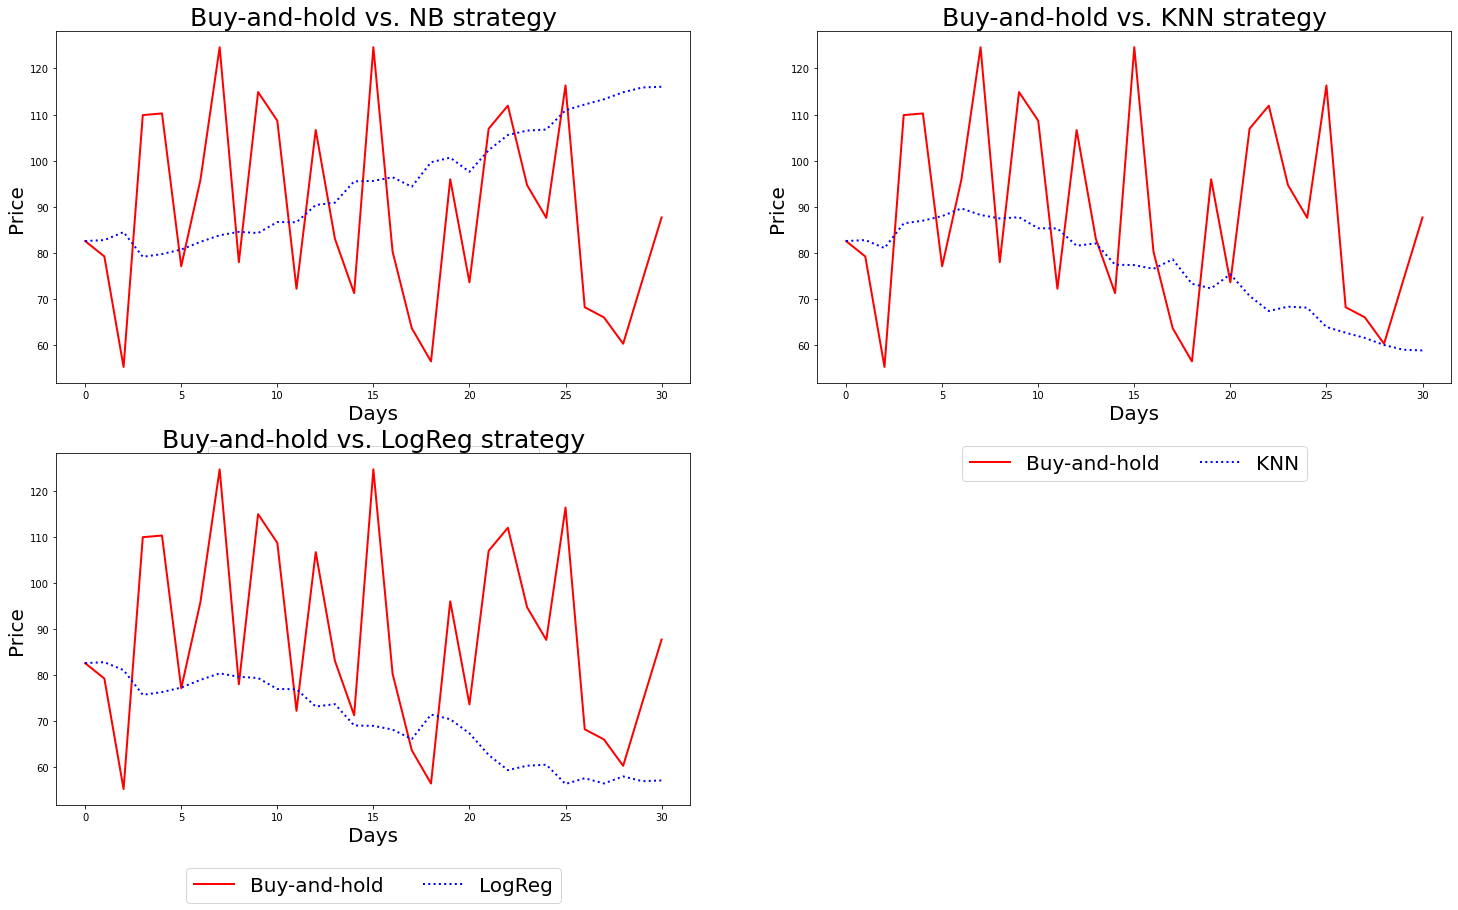

In [255]:
plt.rcParams['figure.figsize'] = 25, 22 
plt.subplot(3,2,1)
plt.plot(X_test_df['Adj Close'],'r',linewidth = 2)
plt.plot(X_test_df['NB_result'],'b',linestyle = ':',linewidth = 2)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Buy-and-hold vs. NB strategy', fontsize=25)
a='Buy-and-hold'
b='NB'
plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)



plt.subplot(3,2,2)
plt.plot(X_test_df['Adj Close'],'r',linewidth = 2)
plt.plot(X_test_df['KNN_result'],'b',linestyle = ':',linewidth = 2)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Buy-and-hold vs. KNN strategy', fontsize=25)
a='Buy-and-hold'
b='KNN'
plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)


plt.subplot(3,2,3)
plt.plot(X_test_df['Adj Close'],'r',linewidth = 2)
plt.plot(X_test_df['LogReg_result'],'b',linestyle = ':',linewidth = 2)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Buy-and-hold vs. LogReg strategy', fontsize=25)
a='Buy-and-hold'
b='LogReg'
plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)